# Text Mining Coursework 2
## Topic: WinterOlympics
### 3 Questions: 
1) What is the dominant sentiment towards the Winter Olympics?

2) Which sport is the most talked about?

3) Which topic is the most popular one on the web, the olympic village, athletes, sports or the venues?

## Libraries Used

In [57]:
import pandas as pd
import tweepy
import requests
import gensim
import gensim.corpora as corpora
import re
import emoji
import nltk
import os
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis
import warnings
import en_core_web_md
import spacy # need have spacy version >=3.2.3
import en_core_web_trf
import numpy as np
import matplotlib.pyplot as plt
from spacy_entity_linker import EntityLinker
from spacy.language import Language
from access_token import tokens
from wordcloud import WordCloud
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from pprint import pprint
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm import tqdm

# ignore warnings for now
warnings.filterwarnings("ignore")

# may need to download a few packages
# !pip install spacy
# !pip install tweepy
# !pip install wordcloud
# !pip install gensim
# !pip install pyldavis
# !pip install vaderSentiment
# !pip install spacy-transformers
# !pip install spacy-entity-linker
# !python -m spacy download en_core_web_trf  ### 460 MB
# !python -m spacy download en_core_web_md   ### 30 MB
# !python -m spacy_entity_linker download "knowledge_base"
# !pip install spacy-entity-linker

# Configuring Twitter API

In [3]:
# auth = tweepy.OAuthHandler(tokens['api_token'], tokens['api_token_secret'])
# auth.set_access_token(tokens['access_token'], tokens['access_token_secret'])

auth = tweepy.OAuth1UserHandler(tokens['api_token'], tokens['api_token_secret'], tokens['access_token'], tokens['access_token_secret'])
api = tweepy.API(auth, wait_on_rate_limit=True)

# Download dataset

We use a command $snscrape 'twitter-search "#WinterOlympics since:2022-02-04 until:2021-02-20" > scraped_tweets.txt'$ to download the dataset.
Dates "2022-02-04" and "2021-02-20" are the start and end date of winter Olympics in Beijing 2022 respectively. The command gives all tag-related tweets in a form of urls, so we need to process them followed by converting to a pandas DataFrame.

In [ ]:
# tweet_urls = pd.read_csv("scraped_tweets.txt", index_col= None, header = None, names = ["tweet_urls"])
# print(tweet_urls)

## Convert urls to tweets

In [ ]:
# # Extract the tweet id
# tweet_ids = lambda x: x["tweet_urls"].split("/")[-1]
# # Store tweet id in another column
# tweet_urls['tweet_ids'] = tweet_urls.apply(tweet_ids, axis=1)
# ids = tweet_urls['tweet_ids'].tolist()

# def url2tweet(IDs): # a list of ids, max 100
#     all_status = api.lookup_statuses(IDs)
#     tweets_list = [[status.created_at, status.user.name, status.user.location, status.text] for status in all_status]
#     return tweets_list


# def get_all_tweets(IDs): # a list of ids
#     num_sections = (len(IDs) - 1) // 100 + 1
#     first_section = ids[:100]
#     data = url2tweet(first_section)
#     for i in tqdm(range(1, num_sections)):
#         current_ids = ids[i*100:(i+1)*100]
#         current_tweet_list = url2tweet(current_ids)
#         data = np.concatenate([data, current_tweet_list])
#     return data

# data = get_all_tweets(ids)

In [ ]:
# tweets_df = pd.DataFrame(data=data, columns=['date', 'user', 'location', 'text'])
# tweets_df.to_csv("data.csv", quotechar='"', encoding='utf8', index = False, header=True)
# tweets_df.head(len(tweets_df))

# Data Cleaning

In [4]:
def remove_emoji(string):
    string = emoji.get_emoji_regexp().sub(u'', string)
    return string

# emojis = '(｀ヘ´) 🤗⭕🤓🤔🤘🦁⭐🆗🆖🈲🤐🤗🤖🤑🆙⏩🥌🍒💚🏅'
# print(remove_emoji(emojis))

In [5]:
def data_cleaning(data):
    # Remove hyperlinks
    data.text = data.text.map(lambda x: re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', x))

    # Remove punctuation
    data.text = data.text.map(lambda x: re.sub('[,\\!?…]', ' ', x))

    # Remove unnecessary line breaks
    data.text = data.text.map(lambda x: re.sub(r"\n", '', x))

    # Convert the titles to lowercase
    data.text = data.text.map(lambda x: x.lower())

    # Remove emojis
    data.text = data.text.map(lambda x: remove_emoji(x))

In [6]:
# Uncomment the line below if loading from previously saved CSV
tweets_df = pd.read_csv('data.csv', quotechar='"', encoding='utf8')

data_cleaning(tweets_df)

# store the processed tweets to csv
tweets_df.to_csv ('data_cleaned.csv', quotechar='"', encoding='utf8', index = False, header=True)

# Task 2: Which sport is the mostly talked about?

## Exploration using a word cloud

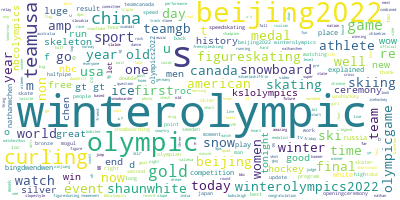

In [7]:
tweets_df = pd.read_csv('data_cleaned.csv', quotechar='"', encoding='utf8')

# get all tweets without duplication
unique_tweets = list(set(list(tweets_df['text'].values)))
unique_tweets = [t for t in unique_tweets if t]

# join the words of the different tweets together into one string
long_string = ' '.join(unique_tweets)
new_long_string = ' '.join(set(long_string.split(" ")))

# create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# generate a word cloud
wordcloud.generate(new_long_string)

# visualize the word cloud
wordcloud.to_image()

## Topic Modelling

### Configuring Stopwords

In [26]:
# get stopwords from nltk library, without outputing the download information to terminal
nltk.download('stopwords', quiet=True)

stop_words = stopwords.words('english')

# add more stopwords
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'winterolympic', 'olympic', 'winterolympics',
                   'olympics', 'beijing','winterparalympic', 'beijing2022', 'winter', 'team', 'gold',
                   'silver', 'bronze', 'medal', 'china', 'russia', 'today', 'like', 'usa', 'would',
                   'watch', 'ceremony', 'men', 'women', 'opening', 'tonight', 'first', 'time', 'go',
                   'next', 'events', 'let', 'best', 'love', 'event', 'athletes', 'games', 'year',
                   'watching', 'canada', 'speed', 'final', 'day', 'run', 'big', 'live', 'know', 'well',
                   'going', 'win', 'great', 'get', 'canada', 'one', 'us', 'good', 'th', 'white', 'back',
                   'game', 'sports', 'nbc', 'amp', 'end', 'see', 'shaun', 'medals'])

# print(stop_words)
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

# get the tweets in a list
data = tweets_df.text.values.tolist()

data_words = list(sent_to_words(data))

# remove stop words
data_words = remove_stopwords(data_words)
# print(data_words)

## Get the Mostly Talked Sports

In [27]:
# create a dictionary
id2word = corpora.Dictionary(data_words)

# create a corpus
texts = data_words

# convert the corpus into a BoW representation
corpus = [id2word.doc2bow(text) for text in texts]

# set number of topics
num_topics = 5

# build an LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics)

# print keywords in each topic
pprint(lda_model.print_topics())

[(0,
  '0.022*"teamusa" + 0.018*"curling" + 0.008*"ice" + 0.006*"shaunwhite" + '
  '0.004*"got" + 0.004*"teamgb" + 0.004*"amazing" + 0.004*"halfpipe" + '
  '0.004*"congratulations" + 0.004*"skater"'),
 (1,
  '0.015*"skating" + 0.011*"curling" + 0.011*"figure" + 0.008*"snowboard" + '
  '0.006*"teamusa" + 0.005*"short" + 0.005*"sport" + 0.004*"chen" + '
  '0.004*"nathan" + 0.004*"ice"'),
 (2,
  '0.012*"curling" + 0.011*"figureskating" + 0.006*"skating" + 0.006*"really" '
  '+ 0.005*"ice" + 0.005*"teamusa" + 0.004*"years" + 0.003*"snowboard" + '
  '0.003*"figure" + 0.003*"skate"'),
 (3,
  '0.011*"curling" + 0.009*"skiing" + 0.008*"hockey" + 0.007*"teamusa" + '
  '0.006*"teamgb" + 0.006*"snowboarding" + 0.005*"figureskating" + 0.005*"new" '
  '+ 0.004*"nbcolympics" + 0.004*"ice"'),
 (4,
  '0.005*"hockey" + 0.005*"ski" + 0.004*"teamusa" + 0.004*"new" + '
  '0.004*"coverage" + 0.004*"curling" + 0.004*"last" + 0.004*"skiing" + '
  '0.004*"nathan" + 0.004*"snow"')]


### Visualise the topics

In [28]:
doc_lda = lda_model[corpus]

pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./'+str(num_topics))

LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)

# uncomment this if you want to save LDAvis_prepared file
# with open(LDAvis_data_filepath, 'wb') as f:
#     pickle.dump(LDAvis_prepared, f)
# f.close()

# with open(LDAvis_data_filepath, 'rb') as f:
#     LDAvis_prepared = pickle.load(f)
# f.close()

pyLDAvis.save_html(LDAvis_prepared, './saved_topics.html')

LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.014239  0.038540       1        1  22.773562
0     -0.029538  0.039673       2        1  21.556830
2     -0.065822 -0.041975       3        1  18.927890
3      0.031437  0.018603       4        1  18.581009
4      0.049683 -0.054840       5        1  18.160709, topic_info=              Term         Freq        Total Category  logprob  loglift
100        teamusa  3175.000000  3175.000000  Default  30.0000  30.0000
40         skating  2158.000000  2158.000000  Default  29.0000  29.0000
74          skiing  1094.000000  1094.000000  Default  28.0000  28.0000
240  figureskating  1559.000000  1559.000000  Default  27.0000  27.0000
114         hockey  1276.000000  1276.000000  Default  26.0000  26.0000
..             ...          ...          ...      ...      ...      ...
242        valieva   143.136707   680.823880   Topic5  -6.0836   0.1464
203         figure   173.554094  1551.141786   Topic5  -5.8910  -0.4843
141           ever   138.798132   619.522566   Topic5  -6.1144   0.2100
115            ice   145.154026  1682.719495   Topic5  -6.0697  -0.7445
185            two   137.031262   740.187026   Topic5  -6.1272   0.0192

[478 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
13867      4  0.787880         aac
533        1  0.152104  absolutely
533        2  0.152104  absolutely
533        3  0.148868  absolutely
533        4  0.394823  absolutely
...      ...       ...         ...
440        2  0.175875         yet
440        3  0.508612         yet
440        4  0.137848         yet
440        5  0.047534         yet
5194       5  0.877518          za

[1225 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3, 4, 5])

# Hence, from the visualisation above we can conclude, the sports mostly talked about are:
$teamusa$, $skating$, $skiing$, $hockey$, $curling$ and $snowboard$

# Task 1: What is the dominant sentiment towards the Winter Olympics?

# Sentiment Analysis

In [53]:
all_pos = []
all_neg = []
dates = np.arange(4, 20)
for date in dates:
    neu = []
    pos = []
    neg = []
    
    if date >= 10:
        cur_date = '2022-02-%s'
    else:
        cur_date = '2022-02-0%s'
    cur_date = cur_date%date
    tweets_df_copy = tweets_df.loc[tweets_df['date'].str.contains(cur_date)]
    
    # Removing duplicate tweets
    unique_tweets = list(set(list(tweets_df_copy['text'].values)))
    unique_tweets = [t for t in unique_tweets if t]
    
    analyzer = SentimentIntensityAnalyzer()
    for tweet_text in unique_tweets:
        vs = analyzer.polarity_scores(tweet_text)
        pos.append(vs['pos'])
        neg.append(vs['neg'])
    
    all_pos.append(pos)
    all_neg.append(neg)

## Get rates of positive/negative

In [54]:
rates = []
for i in range(len(all_pos)):
    cur_pos = [x for x in all_pos[i] if x > 0.3]
    cur_neg = [x for x in all_neg[i] if x > 0.3]
    rates.append(len(cur_pos)/len(cur_neg))

## Visualise the rates

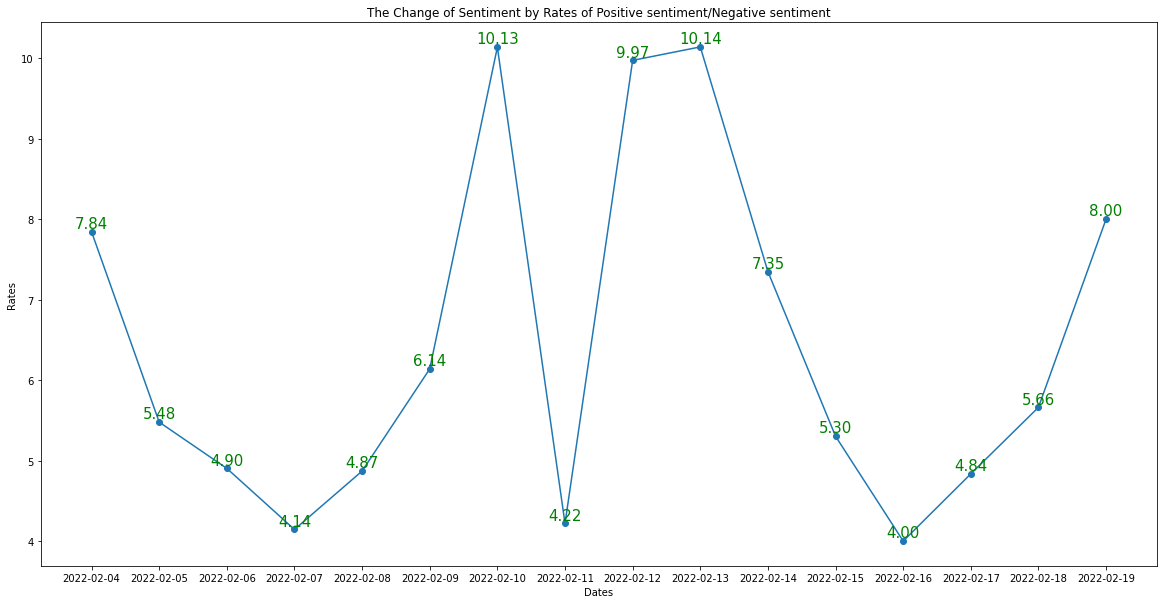

In [68]:
labels = []
for date in dates:
    if date >= 10:
        cur_date = '2022-02-%s'
    else:
        cur_date = '2022-02-0%s'
    cur_date = cur_date%date
    labels.append(cur_date)
    
plt.figure(figsize=(20,10))
plt.plot(rates, 'o-')
plt.xticks(range(len(labels)), labels)
plt.xlabel('Dates')
plt.ylabel('Rates')
plt.title("The Change of Sentiment by Rates of Positive sentiment/Negative sentiment")
x = dates
y = np.array(rates)
for _x, _y in zip(x, y):
    plt.text(_x-4, _y+0.01, '%.2f'%_y, ha='center', va='bottom', size=15, c='green')
plt.show()

# Task 3: Which topic is the most popular one on the web, the olympic village, athletes, sports or the venues?

# Named Entity Recognition

In [69]:
nlp = spacy.load('en_core_web_trf') # Transformer based pre-trained model 438 MB

In [71]:
# athletes = []
# countries = []

# for tweet_text in unique_tweets:
#     doc = nlp(tweet_text)
#     for ne in doc.ents:
#         if ne.label_ == 'ORG' or ne.label_ == 'GPE' or ne.label_ == 'LOC':
            

# Named Entity Linking

In [ ]:
# nlp = spacy.load("en_core_web_md")

# #add to pipeline
# nlp.add_pipe('entityLinker', last=True)

In [ ]:
# for tweet_text in unique_tweets:
#     try:
#         doc = nlp(tweet_text)
#         print(tweet_text)
#         all_linked_entities = doc._.linkedEntities
#         for linked_entity in all_linked_entities:
#             print(linked_entity.get_url() + ' ' + linked_entity.pretty_string(True))
#         print()
#     except:
#         pass